# MultiClass Vehicle Detection Model Training

## imports

In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
import os
import random
from pathlib import Path
from ultralytics import YOLO
import shutil
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import requests
from datetime import datetime
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!nvidia-smi

Wed Jul 23 17:26:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             50W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Quick look at the COCO dataset

In [4]:
annotationTrainFile = '/content/instances_train2017.json'
annotationValFile='/content/instances_val2017.json'


In [5]:
cocoVal = COCO(annotationValFile)

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [6]:
cocoTrain = COCO(annotationTrainFile)

loading annotations into memory...
Done (t=16.10s)
creating index...
index created!


In [7]:
print(f'num images: {len(cocoTrain.getImgIds())}')
print(f'num annotations: {len(cocoTrain.getAnnIds())}')

num images: 118287
num annotations: 860001


num of bouding boxes ^


In [8]:
cocoTrain.loadCats(cocoTrain.getCatIds()) == cocoVal.loadCats(cocoVal.getCatIds())

True

In [9]:
categories = cocoTrain.loadCats(cocoTrain.getCatIds())

In [10]:
annotations = cocoTrain.loadAnns(cocoTrain.getAnnIds())
print(len(annotations))

860001


In [11]:
annotations = cocoVal.loadAnns(cocoVal.getAnnIds())
#annotations[0]

In [12]:
def cleanAnnotations(annotations):
  bad_anns = []

  for ann in annotations:
    if 'bbox' not in ann:
      bad_anns.append(ann['id'])
    else:
      _,_,w,h = ann['bbox']
      if w <= 1 or h <= 1:
        bad_anns.append(ann['id'])
  print(f"all annotations: {len(annotations)}")
  print(f"Bad annotations: {len(bad_anns)}")
  print(f"Bad annotations: {(bad_anns)}")
  # drop themm

  cleaned_ann = [ann for ann in annotations if ann['id'] not in bad_anns]
  print(f"cleaned annotations: {len(cleaned_ann)}")
  valid_image_ids = {ann['image_id'] for ann in cleaned_ann}
  return cleaned_ann, valid_image_ids


In [13]:
def classCounts(cocoAnn, classes=None):
  category_counts = {}
  if classes:
    category_ids = cocoAnn.getCatIds(catNms=classes)
  else:
    category_ids = cocoAnn.getCatIds()
  categories = cocoAnn.loadCats(category_ids)
  id_name = {cat['id']: cat['name'] for cat in categories}

  annotations = cocoAnn.loadAnns(cocoAnn.getAnnIds(catIds=category_ids)) # filter out classes if given (vehicles)
  cleaned_ann, _ = cleanAnnotations(annotations)
  for ann in cleaned_ann:
    c_id = ann['category_id']
    if c_id in category_counts:
      category_counts[c_id] += 1
    else:
      category_counts[c_id] = 1

  for id, count in category_counts.items():
    print(f'{id_name[id]} count : {count} instances')


  labels = [id_name[cat_id] for cat_id in category_counts.keys()]
  counts = [category_counts[cat_id] for cat_id in category_counts.keys()]

  # Plotting
  plt.figure(figsize=(12, 6))
  plt.bar(labels, counts, color='skyblue')
  plt.xticks(rotation=45, ha='right')
  plt.title('Instance Counts per Category')
  plt.xlabel('Category')
  plt.ylabel('Number of Instances')
  plt.tight_layout()
  plt.show()



all annotations: 860001
Bad annotations: 48
Bad annotations: [918, 1893538, 1977900, 2032133, 2126045, 2216837, 1480783, 2047149, 2073979, 1637247, 2200824, 660563, 2092190, 2144380, 1856369, 1864197, 1864550, 2123652, 1400800, 300223, 650932, 1482147, 1720260, 1808447, 1813938, 1816247, 1816254, 1839125, 1839790, 1847412, 1849197, 1852584, 1852762, 1853108, 1984796, 2008730, 2056510, 2064476, 2079773, 2084026, 2087312, 2091682, 2179972, 2201465, 2201522, 2203355, 2203397, 2206849]
cleaned annotations: 859953
hot dog count : 2917 instances
dog count : 5508 instances
potted plant count : 8652 instances
tv count : 5805 instances
bird count : 10801 instances
cat count : 4768 instances
horse count : 6587 instances
sheep count : 9509 instances
cow count : 8147 instances
bottle count : 24342 instances
couch count : 5779 instances
chair count : 38489 instances
dining table count : 15714 instances
bicycle count : 7113 instances
car count : 43866 instances
motorcycle count : 8725 instances
airp

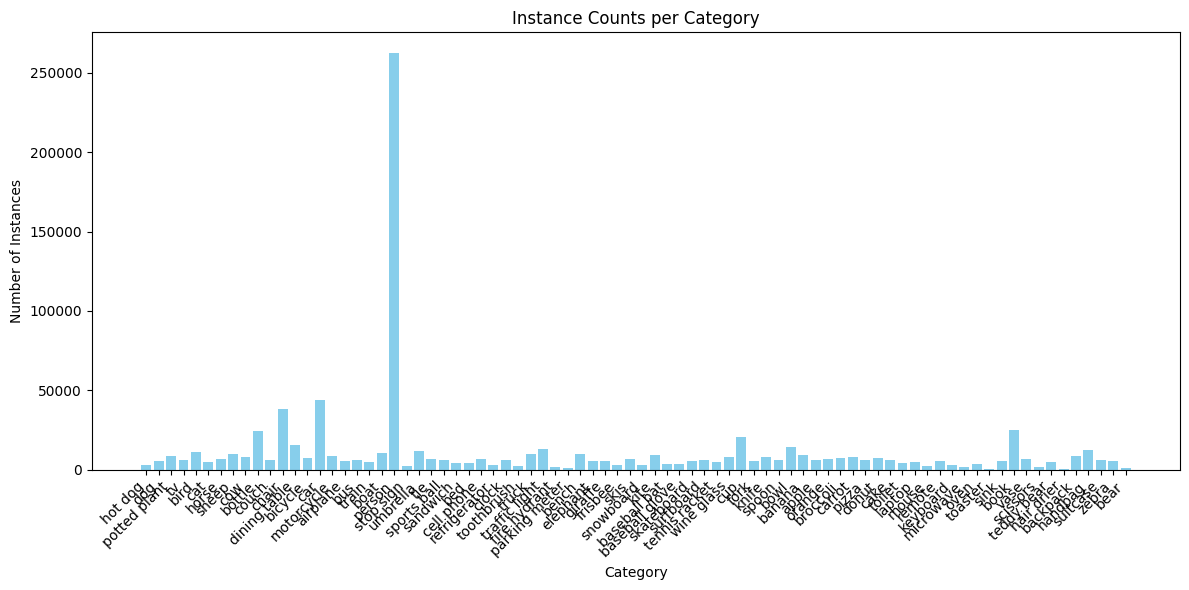

In [14]:
classCounts(cocoTrain)

all annotations: 48635
Bad annotations: 1
Bad annotations: [2047149]
cleaned annotations: 48634
cat count : 4768 instances
car count : 43866 instances


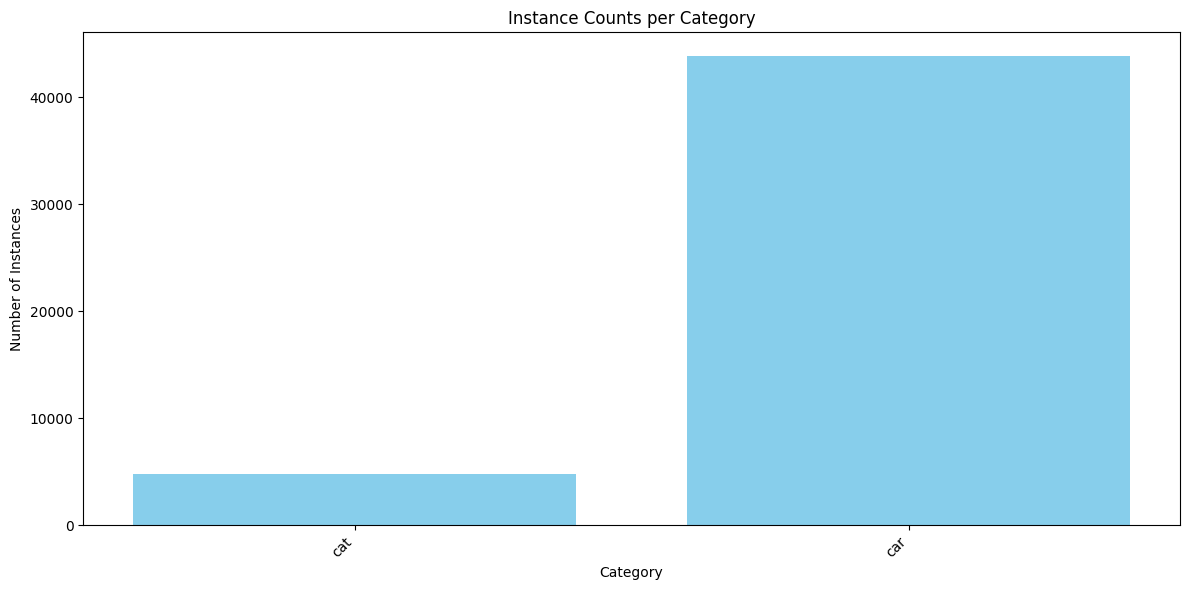

In [15]:
# number of objects per class, see how many times the class shows up in entire dataset
classCounts(cocoTrain,['car','cat'])

all annotations: 36781
Bad annotations: 1
Bad annotations: [2202383]
cleaned annotations: 36780
dog count : 218 instances
potted plant count : 343 instances
tv count : 288 instances
bird count : 440 instances
cat count : 202 instances
horse count : 273 instances
sheep count : 361 instances
cow count : 380 instances
bottle count : 1025 instances
couch count : 261 instances
chair count : 1791 instances
dining table count : 697 instances
bicycle count : 316 instances
car count : 1932 instances
motorcycle count : 371 instances
airplane count : 143 instances
bus count : 285 instances
train count : 190 instances
boat count : 430 instances
person count : 11004 instances
stop sign count : 75 instances
umbrella count : 413 instances
tie count : 254 instances
sandwich count : 177 instances
bed count : 163 instances
cell phone count : 262 instances
refrigerator count : 126 instances
clock count : 267 instances
toothbrush count : 57 instances
truck count : 415 instances
traffic light count : 637 i

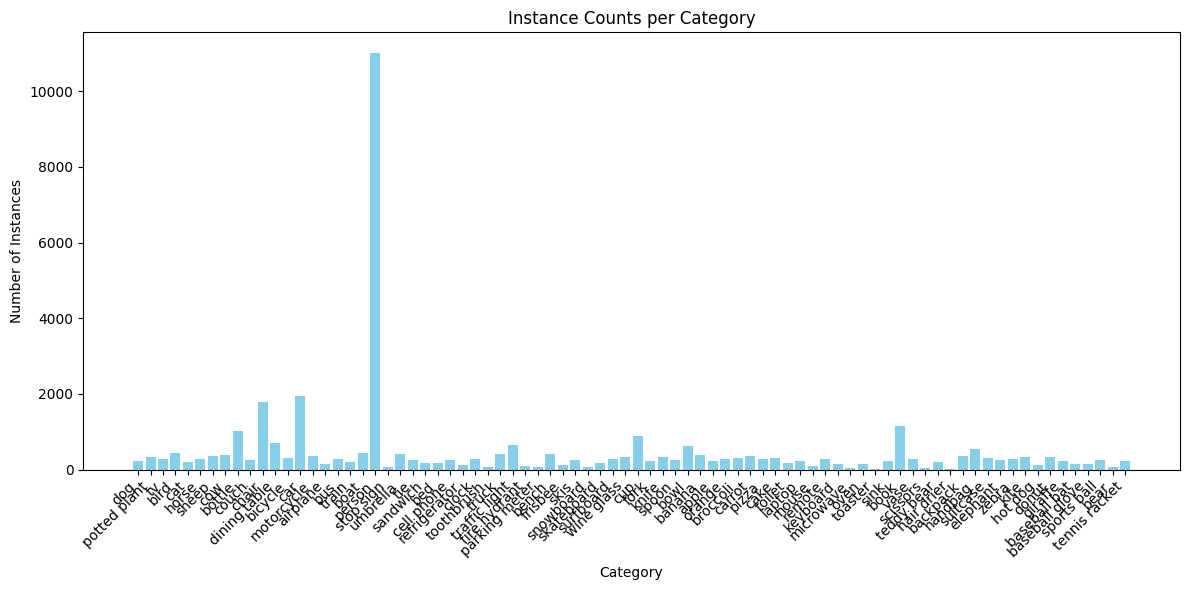

In [16]:
# now for val set
classCounts(cocoVal)

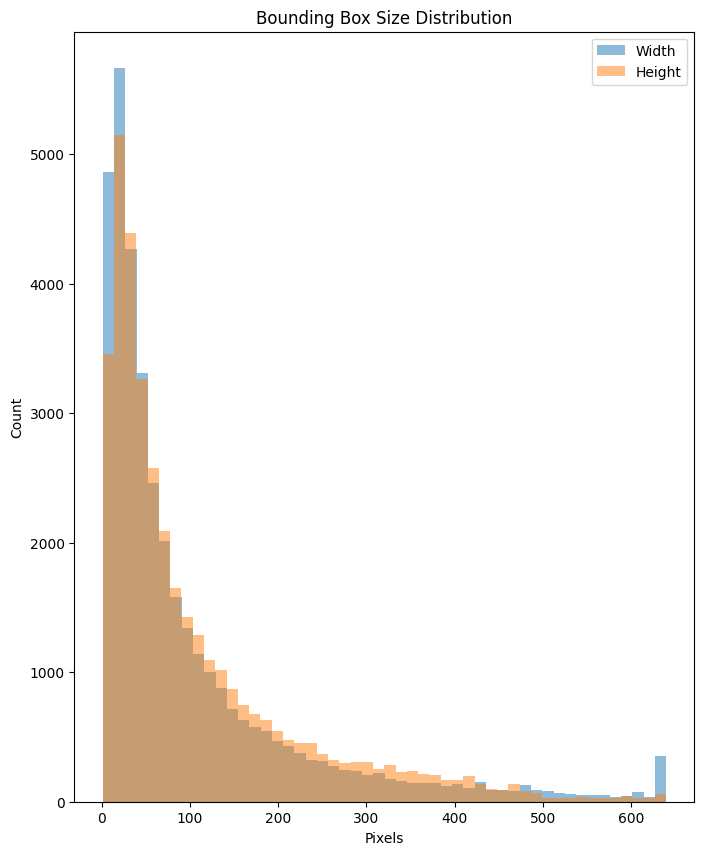

In [17]:
# checking bbox distributions
widths = []
heights = []

for ann in annotations:
    bbox = ann['bbox']  # format: [x, y, width, height]
    widths.append(bbox[2])
    heights.append(bbox[3])

plt.hist(widths, bins=50, alpha=0.5, label='Width')
plt.hist(heights, bins=50, alpha=0.5, label='Height')
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.title("Bounding Box Size Distribution")
plt.legend()
plt.show()


i want to make sure to include negative images as well so the model will generalise well, the negatives should include classes from outside the superclass, different classes within the vehicle superclass and ideally some golden negatives (background only)

## preping data and functions

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
DATA_DIR = Path('coco_subset_1')
TRAIN_DIR = DATA_DIR / 'images/train'
VAL_DIR = DATA_DIR / 'images/val'
LABEL_TRAIN_DIR = DATA_DIR / 'labels/train'
LABEL_VAL_DIR = DATA_DIR / 'labels/val'

In [20]:
vehicle_classes = ['bus', 'car', 'truck']
negative_classes = ['cat','bench','fire hydrant','traffic light','person'] # need to make sure the images dont contain vehicles?

In [21]:
# def get_negative_image_ids(coco, exclude_classes, num_needed):
#   '''ensures the images that dont contain any of the positives could be used as negatives'''
#     all_img_ids = coco.getImgIds()
#     excluded_ids = set()
#     for cname in exclude_classes:
#         cat_id = coco.getCatIds(catNms=[cname])[0]
#         anns = coco.loadAnns(coco.getAnnIds(catIds=[cat_id]))
#         excluded_ids.update(ann['image_id'] for ann in anns)

#     neg_ids = list(set(all_img_ids) - excluded_ids)
#     random.shuffle(neg_ids)
#     return neg_ids[:num_needed]
from collections import defaultdict

def group_anns_by_image(annotations):
    grouped = defaultdict(list)
    for ann in annotations:
        grouped[ann['image_id']].append(ann)
    return grouped

def get_negative_image_ids(coco, negative_classes, exclude_classes, num_needed):
    # Load all annotations once
    all_ann_ids = coco.getAnnIds()
    all_anns = coco.loadAnns(all_ann_ids)

    # Clean and group annotations
    cleaned_anns, valid_image_ids = cleanAnnotations(all_anns)
    anns_by_image = group_anns_by_image(cleaned_anns)

    negative_cat_ids = set(coco.getCatIds(catNms=negative_classes))
    exclude_cat_ids = set(coco.getCatIds(catNms=exclude_classes))

    matching_img_ids = []
    background_img_ids = []

    for img_id in valid_image_ids:
        anns = anns_by_image[img_id]  # already cleaned, no need to load again
        if not anns:
            background_img_ids.append(img_id)
            continue

        cat_ids_in_image = {ann['category_id'] for ann in anns}

        if cat_ids_in_image & negative_cat_ids and not cat_ids_in_image & exclude_cat_ids:
            matching_img_ids.append(img_id)
    negatives = matching_img_ids + background_img_ids
    random.shuffle(negatives)
    return negatives[:num_needed]


In [22]:
def get_vehicle_img_ids(coco, include_classes, num_needed_per_class):
  '''gets image ids for vehicles with a balanced sampling approach'''
  final_img_ids = set()

  for cls in include_classes:  # couldve tried to improve and use only 1 api call
    cat_id = coco.getCatIds(catNms=[cls])[0]
    ann_ids = coco.getAnnIds(catIds=[cat_id])
    annotations = coco.loadAnns(ann_ids)

    unique_img_ids = list({ann['image_id'] for ann in annotations})
    random.shuffle(unique_img_ids)

    # Take only the images we haven't seen before
    new_img_ids = [img_id for img_id in unique_img_ids if img_id not in final_img_ids][:num_needed_per_class]
    final_img_ids.update(new_img_ids)

  return list(final_img_ids)


In [23]:
def create_dirs(dir_paths,pos_class_size):
  for path in dir_paths:
    path = Path(path)
    path.mkdir(parents=True, exist_ok=True)

    # full_path = Path(f"{path}_{pos_class_size}")
    # full_path.mkdir(parents=True, exist_ok=True)

In [24]:
def write_to_yaml(DATA_DIR, file_name='data.yaml'):
  with open(DATA_DIR /file_name, 'w') as f:
    f.write(f"""
path: {DATA_DIR}
train: images/train
val: images/val
nc: 3
names: ['bus', 'car', 'truck']""")

In [25]:
def download_and_save_image(coco, img, out_dir):
    url = img['coco_url']
    out_path = out_dir / img['file_name']
    if not out_path.exists():
        img_data = requests.get(url).content
        with open(out_path, 'wb') as f:
            f.write(img_data)

In [26]:
def write_yolo_label_file(anns, out_label_path, img_w, img_h, category_id_map):
    with open(out_label_path, 'w') as f:
        for ann in anns:
            if 'bbox' not in ann or ann['bbox'][2] < 1 or ann['bbox'][3] < 1:
                continue
            x, y, w, h = ann['bbox']
            # Convert to YOLO format
            cx = (x + w / 2) / img_w
            cy = (y + h / 2) / img_h
            w /= img_w
            h /= img_h
            class_id = category_id_map[ann['category_id']]
            f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

In [27]:
def prepare_dataset(coco, img_ids, label_dir, image_dir, category_id_map, num_threads=8):
    '''function to prepare dataset by gathering target images and negatives
     and creating yolo label file suitable for training.
     previous version was a for loop with api call within it
     and sequential processing and was taking too much time
    '''
    # Batch load all image info and annotations first
    img_id_to_img = {img['id']: img for img in coco.loadImgs(img_ids)}
    ann_id_to_img = {img_id: [] for img_id in img_ids}
    for ann in coco.loadAnns(coco.getAnnIds(imgIds=img_ids)):
        ann_id_to_img[ann['image_id']].append(ann)

    def process(img_id):
        try:
            img = img_id_to_img[img_id]
            anns = ann_id_to_img[img_id]

            img_path = image_dir / img['file_name']
            label_path = label_dir / img['file_name'].replace('.jpg', '.txt')

            download_and_save_image(coco, img, image_dir)

            filtered_anns = [a for a in anns if a['category_id'] in category_id_map]
            if filtered_anns:
                write_yolo_label_file(filtered_anns, label_path, img['width'], img['height'], category_id_map)
            else:
                label_path.touch()  # empty file if no valid annotations
        except Exception as e:
            print(f"[ERROR] Failed processing image {img_id}: {e}")


    # Parallel processing
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        list(tqdm(executor.map(process, img_ids), total=len(img_ids)))


In [28]:
def pretrain(cocoVal, cocoTrain, vehicle_classes, negative_classes, num_samples_pos_train, num_samples_neg_train, num_samples_pos_val, num_samples_neg_val):
  dirs = [TRAIN_DIR,VAL_DIR,LABEL_TRAIN_DIR,LABEL_VAL_DIR]
  create_dirs(dirs, num_samples_pos_train)
  cat_id_map = {}
  for idx, cname in enumerate(vehicle_classes):
      cat_id = cocoTrain.getCatIds(catNms=[cname])[0]
      cat_id_map[cat_id] = idx

  train_pos_ids = get_vehicle_img_ids(cocoTrain, vehicle_classes, num_samples_pos_train)
  train_neg_ids = get_negative_image_ids(cocoTrain,negative_classes, vehicle_classes, num_samples_neg_train)
  prepare_dataset(cocoTrain, train_pos_ids + train_neg_ids, LABEL_TRAIN_DIR, TRAIN_DIR, cat_id_map)

  # now for validation set
  val_pos_ids = get_vehicle_img_ids(cocoVal, vehicle_classes, num_samples_pos_val)
  val_neg_ids = get_negative_image_ids(cocoVal, negative_classes, vehicle_classes, num_samples_neg_val)
  prepare_dataset(cocoVal, val_pos_ids + val_neg_ids, LABEL_VAL_DIR, VAL_DIR, cat_id_map)

  # create data.yaml for yolo
  print(f'DATA DIR : {DATA_DIR}')
  write_to_yaml(DATA_DIR)


## Transfer Learning with Pretrained model

In [29]:
def train_yolo_model(
    model_name,
    data_yaml_path,
    epochs=100,
    patience=10,
    img_size=640,
    project="runs/train",
    name=None,
    save_dir="models",
    export=False,
    export_format="onnx",
    quantize=False,
):
    """
    Train a YOLOv8 model and save the entire experiment folder + export if needed.

    Args:
        model_name (str): e.g., 'yolov8n.pt', 'yolov8s.pt'
        data_yaml_path (str or Path): path to data.yaml
        epochs (int): number of training epochs
        patience (int): early stopping patience
        img_size (int): image resolution
        project (str): where to store YOLO training runs
        name (str): experiment name
        save_dir (str): permanent storage path (e.g., Google Drive)
        export (bool): whether to export the model
        export_format (str): format to export to ('onnx', 'torchscript', etc.)
        quantize (bool): use quantization (only some formats support)
    """
    model = YOLO(model_name)
    experiment_name = name or model_name.replace(".pt", "") + "_" + datetime.now().strftime("%Y%m%d_%H%M%S")

    # === Train ===
    results = model.train(
        data=str(data_yaml_path),
        epochs=epochs,
        imgsz=img_size,
        patience=patience,
        project=project,
        name=experiment_name,
        verbose=True
    )

    # === Paths ===
    run_path = Path(project) / experiment_name
    save_path = Path(save_dir) / experiment_name
    save_path.mkdir(parents=True, exist_ok=True)

    # === Copy entire experiment folder (weights, results, etc.) ===
    shutil.copytree(run_path, save_path, dirs_exist_ok=True)
    print(f" Saved entire experiment folder to: {save_path}")

    # === Export Model ===
    if export:
        print(f" Exporting model to {export_format} {'(quantized)' if quantize else ''}...")
        model.export(format=export_format, int8=quantize)
        print(f" Exported model to {export_format}")

    return model, results



In [44]:
#folder_path = '/content/coco_subset_2'
# Remove the folder and its contents using shell command
#!rm -rf {folder_path}

In [31]:
pretrain(cocoVal, cocoTrain, vehicle_classes, negative_classes,500,400,100,80)


all annotations: 860001
Bad annotations: 48
Bad annotations: [918, 1893538, 1977900, 2032133, 2126045, 2216837, 1480783, 2047149, 2073979, 1637247, 2200824, 660563, 2092190, 2144380, 1856369, 1864197, 1864550, 2123652, 1400800, 300223, 650932, 1482147, 1720260, 1808447, 1813938, 1816247, 1816254, 1839125, 1839790, 1847412, 1849197, 1852584, 1852762, 1853108, 1984796, 2008730, 2056510, 2064476, 2079773, 2084026, 2087312, 2091682, 2179972, 2201465, 2201522, 2203355, 2203397, 2206849]
cleaned annotations: 859953


100%|██████████| 1900/1900 [05:08<00:00,  6.17it/s]


all annotations: 36781
Bad annotations: 1
Bad annotations: [2202383]
cleaned annotations: 36780


100%|██████████| 380/380 [01:01<00:00,  6.13it/s]

DATA DIR : coco_subset_1


In [32]:
DATA_YAML_PATH = DATA_DIR / 'data.yaml'

model, results = train_yolo_model(
    model_name="yolo11n.pt",
    data_yaml_path=DATA_YAML_PATH,
    epochs=100,
    name="vehicle_detection_exp_11n",
    save_dir="/content/drive/MyDrive/yolo_models_exp"  # Google Drive path
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 414MB/s]


Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco_subset_1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_detection_exp_11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots

100%|██████████| 755k/755k [00:00<00:00, 68.9MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,425 parameters, 2,590,409 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2195.1±1328.5 MB/s, size: 209.1 KB)


train: Scanning /content/coco_subset_1/labels/train... 1900 images, 400 backgrounds, 0 corrupt: 100%|██████████| 1900/1900 [00:01<00:00, 1614.49it/s]

train: New cache created: /content/coco_subset_1/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 693.0±89.9 MB/s, size: 135.1 KB)


val: Scanning /content/coco_subset_1/labels/val... 380 images, 80 backgrounds, 0 corrupt: 100%|██████████| 380/380 [00:00<00:00, 1307.88it/s]


val: New cache created: /content/coco_subset_1/labels/val.cache
Plotting labels to runs/train/vehicle_detection_exp_11n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/vehicle_detection_exp_11n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.42G      1.285      2.541      1.228         73        640: 100%|██████████| 119/119 [00:15<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]


                   all        380       1222      0.504      0.279      0.289      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.71G      1.417      2.151        1.3         83        640: 100%|██████████| 119/119 [00:13<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.63it/s]

                   all        380       1222      0.365       0.35      0.299      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.72G      1.507      2.159      1.396         77        640: 100%|██████████| 119/119 [00:12<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]

                   all        380       1222      0.313      0.387       0.31       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.73G      1.499      2.034      1.381         56        640: 100%|██████████| 119/119 [00:12<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.92it/s]

                   all        380       1222      0.384      0.288      0.264      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.75G      1.467      1.931      1.378         53        640: 100%|██████████| 119/119 [00:12<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.68it/s]

                   all        380       1222      0.391      0.333      0.273      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.76G      1.438      1.855      1.338         76        640: 100%|██████████| 119/119 [00:12<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.61it/s]

                   all        380       1222      0.385      0.349      0.317      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.78G      1.412      1.837      1.346         69        640: 100%|██████████| 119/119 [00:12<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.74it/s]

                   all        380       1222      0.423      0.368       0.35      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.79G      1.399      1.766      1.334         94        640: 100%|██████████| 119/119 [00:12<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.44it/s]

                   all        380       1222       0.53      0.345      0.386      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.81G      1.376      1.708      1.307         44        640: 100%|██████████| 119/119 [00:12<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.63it/s]

                   all        380       1222      0.464      0.404      0.374      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.82G      1.344      1.646      1.292         71        640: 100%|██████████| 119/119 [00:12<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.70it/s]

                   all        380       1222      0.504      0.409      0.419      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.84G      1.342      1.632        1.3         98        640: 100%|██████████| 119/119 [00:12<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.61it/s]

                   all        380       1222        0.5      0.438      0.426      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.85G      1.342      1.641      1.292         77        640: 100%|██████████| 119/119 [00:12<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]

                   all        380       1222      0.511      0.369      0.394      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.87G      1.331      1.609      1.276         64        640: 100%|██████████| 119/119 [00:12<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.37it/s]

                   all        380       1222      0.476      0.373      0.382      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.88G      1.292      1.568      1.257         67        640: 100%|██████████| 119/119 [00:12<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.87it/s]

                   all        380       1222      0.551      0.436      0.453      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.89G      1.287      1.548      1.253         60        640: 100%|██████████| 119/119 [00:12<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.84it/s]

                   all        380       1222      0.549      0.434      0.463      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.91G      1.286      1.512      1.247         53        640: 100%|██████████| 119/119 [00:13<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.42it/s]

                   all        380       1222      0.572      0.418      0.462      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.93G      1.256      1.506      1.241         65        640: 100%|██████████| 119/119 [00:12<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.44it/s]

                   all        380       1222      0.537      0.437      0.464      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.94G      1.287      1.467       1.24         43        640: 100%|██████████| 119/119 [00:12<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.68it/s]

                   all        380       1222      0.481      0.435      0.426      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.95G      1.247      1.485      1.244         87        640: 100%|██████████| 119/119 [00:12<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.43it/s]

                   all        380       1222      0.524      0.457      0.477      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.97G       1.25      1.458      1.221         69        640: 100%|██████████| 119/119 [00:12<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.53it/s]

                   all        380       1222      0.623      0.428      0.489      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.98G      1.227      1.423      1.224         51        640: 100%|██████████| 119/119 [00:12<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.89it/s]

                   all        380       1222      0.577       0.44      0.482      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         3G      1.234      1.394      1.216         54        640: 100%|██████████| 119/119 [00:12<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.25it/s]

                   all        380       1222      0.594      0.437      0.475      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.01G      1.219      1.411      1.207         49        640: 100%|██████████| 119/119 [00:12<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]

                   all        380       1222      0.574      0.442      0.484       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.03G      1.203      1.364       1.19        100        640: 100%|██████████| 119/119 [00:12<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.38it/s]

                   all        380       1222      0.576      0.474      0.504      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.04G      1.211      1.362      1.193         67        640: 100%|██████████| 119/119 [00:12<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.74it/s]

                   all        380       1222      0.545      0.456      0.475      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.06G      1.208      1.378      1.204         55        640: 100%|██████████| 119/119 [00:12<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.29it/s]

                   all        380       1222      0.537      0.456      0.477      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.07G      1.208      1.344      1.189         62        640: 100%|██████████| 119/119 [00:12<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.88it/s]

                   all        380       1222      0.549      0.503      0.508      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.09G      1.169      1.314      1.178         53        640: 100%|██████████| 119/119 [00:13<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.65it/s]

                   all        380       1222      0.591       0.47      0.512      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       3.1G       1.17      1.305      1.175         71        640: 100%|██████████| 119/119 [00:12<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.30it/s]

                   all        380       1222      0.575      0.495      0.502      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.12G      1.182      1.324      1.194         67        640: 100%|██████████| 119/119 [00:12<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.61it/s]

                   all        380       1222      0.595      0.476      0.509      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.13G      1.182      1.289      1.175         74        640: 100%|██████████| 119/119 [00:12<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.70it/s]

                   all        380       1222      0.666       0.42      0.504      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.15G      1.157      1.263      1.169         77        640: 100%|██████████| 119/119 [00:12<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.81it/s]

                   all        380       1222      0.596      0.468      0.495      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.16G      1.137      1.276      1.163         85        640: 100%|██████████| 119/119 [00:12<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.05it/s]

                   all        380       1222      0.587      0.475      0.504      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.18G      1.134      1.247      1.155         58        640: 100%|██████████| 119/119 [00:12<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.51it/s]

                   all        380       1222      0.582       0.47      0.503       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.19G      1.149      1.266      1.165         49        640: 100%|██████████| 119/119 [00:12<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.85it/s]

                   all        380       1222      0.635      0.472      0.538      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.21G      1.124      1.217      1.151         47        640: 100%|██████████| 119/119 [00:12<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.73it/s]

                   all        380       1222      0.623      0.473      0.533      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.22G      1.136      1.211      1.154         62        640: 100%|██████████| 119/119 [00:12<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.90it/s]

                   all        380       1222       0.67      0.468      0.526       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.23G      1.145      1.213      1.156         93        640: 100%|██████████| 119/119 [00:12<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.55it/s]

                   all        380       1222      0.663      0.448      0.528      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.25G      1.115      1.187      1.148         69        640: 100%|██████████| 119/119 [00:12<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.50it/s]

                   all        380       1222      0.668      0.464       0.53      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.27G      1.114      1.186       1.14         91        640: 100%|██████████| 119/119 [00:12<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

                   all        380       1222      0.602      0.501      0.533      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.28G      1.098       1.16      1.133         71        640: 100%|██████████| 119/119 [00:12<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.92it/s]

                   all        380       1222      0.616      0.512       0.55      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.29G      1.107      1.154      1.129         72        640: 100%|██████████| 119/119 [00:12<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.80it/s]

                   all        380       1222      0.621      0.464      0.524      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.31G      1.099      1.159      1.139         77        640: 100%|██████████| 119/119 [00:12<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.95it/s]

                   all        380       1222      0.622      0.515      0.545      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.32G      1.108      1.142      1.129         74        640: 100%|██████████| 119/119 [00:12<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.64it/s]

                   all        380       1222      0.632      0.501      0.554      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.34G      1.099      1.142      1.128         82        640: 100%|██████████| 119/119 [00:12<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.06it/s]

                   all        380       1222      0.622      0.519      0.555       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.36G      1.074      1.115      1.123         78        640: 100%|██████████| 119/119 [00:12<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.73it/s]

                   all        380       1222      0.687      0.471      0.532      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.37G      1.095      1.114      1.121         36        640: 100%|██████████| 119/119 [00:12<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.78it/s]

                   all        380       1222      0.599      0.505      0.544      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.38G      1.067        1.1      1.118         83        640: 100%|██████████| 119/119 [00:12<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.70it/s]

                   all        380       1222       0.65      0.509      0.556      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.4G       1.07      1.093       1.11         55        640: 100%|██████████| 119/119 [00:12<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.85it/s]

                   all        380       1222      0.645      0.497      0.554      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.41G      1.066      1.074      1.109         85        640: 100%|██████████| 119/119 [00:12<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.56it/s]

                   all        380       1222        0.6      0.488      0.526      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.43G      1.048       1.08      1.107         74        640: 100%|██████████| 119/119 [00:12<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.87it/s]

                   all        380       1222      0.638      0.496      0.545      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.44G      1.048      1.085      1.104         49        640: 100%|██████████| 119/119 [00:12<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.67it/s]

                   all        380       1222      0.664      0.491      0.547      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.46G      1.054      1.058        1.1         53        640: 100%|██████████| 119/119 [00:12<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.05it/s]

                   all        380       1222      0.606       0.53      0.555      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.47G       1.06      1.066      1.111         67        640: 100%|██████████| 119/119 [00:12<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.93it/s]

                   all        380       1222      0.638      0.493      0.542      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.49G      1.027      1.034      1.095         34        640: 100%|██████████| 119/119 [00:12<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.56it/s]

                   all        380       1222      0.627      0.496      0.541      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.5G      1.029      1.019      1.092         43        640: 100%|██████████| 119/119 [00:12<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.65it/s]

                   all        380       1222       0.62      0.484      0.526      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.52G       1.04      1.012      1.097         84        640: 100%|██████████| 119/119 [00:12<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.91it/s]

                   all        380       1222      0.661      0.493      0.547      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.53G      1.042      1.032      1.094         60        640: 100%|██████████| 119/119 [00:12<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.84it/s]

                   all        380       1222      0.619      0.525      0.547       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.54G      1.037      1.022      1.098         70        640: 100%|██████████| 119/119 [00:12<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.88it/s]

                   all        380       1222      0.656      0.502      0.565      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.56G      1.038      1.007      1.089         48        640: 100%|██████████| 119/119 [00:12<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.84it/s]

                   all        380       1222        0.6      0.542      0.563      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.58G      1.013     0.9879      1.084         65        640: 100%|██████████| 119/119 [00:12<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.94it/s]

                   all        380       1222      0.692      0.471      0.552      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.59G      1.021      1.003      1.087         80        640: 100%|██████████| 119/119 [00:12<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.99it/s]

                   all        380       1222      0.654      0.497      0.552      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.61G      1.007     0.9615      1.075         51        640: 100%|██████████| 119/119 [00:12<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.84it/s]

                   all        380       1222      0.629      0.524      0.564       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.62G       1.03     0.9995      1.089         83        640: 100%|██████████| 119/119 [00:12<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.92it/s]

                   all        380       1222      0.654      0.492      0.554      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.63G          1     0.9611      1.072        101        640: 100%|██████████| 119/119 [00:12<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.87it/s]

                   all        380       1222       0.58      0.555      0.561      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.65G      1.007     0.9675       1.07         33        640: 100%|██████████| 119/119 [00:12<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.06it/s]

                   all        380       1222      0.689      0.502      0.558      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.66G      1.001     0.9538      1.071         71        640: 100%|██████████| 119/119 [00:12<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.96it/s]

                   all        380       1222      0.694      0.493       0.56      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.68G     0.9956     0.9421      1.066         73        640: 100%|██████████| 119/119 [00:12<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.87it/s]

                   all        380       1222       0.65      0.512      0.559      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.69G     0.9939     0.9379      1.069        109        640: 100%|██████████| 119/119 [00:12<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.76it/s]

                   all        380       1222      0.645      0.512      0.562      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.71G     0.9877     0.9425      1.067         65        640: 100%|██████████| 119/119 [00:12<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.89it/s]

                   all        380       1222      0.729      0.463      0.559      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.72G     0.9826     0.9267      1.065         79        640: 100%|██████████| 119/119 [00:12<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.12it/s]

                   all        380       1222      0.622      0.508      0.559       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.74G     0.9946     0.9261      1.071         65        640: 100%|██████████| 119/119 [00:12<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.98it/s]

                   all        380       1222      0.674      0.491      0.545      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.75G     0.9834     0.9143      1.067         40        640: 100%|██████████| 119/119 [00:12<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.04it/s]

                   all        380       1222      0.645      0.525      0.559      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.77G     0.9744     0.9013      1.053         75        640: 100%|██████████| 119/119 [00:12<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.78it/s]

                   all        380       1222      0.675      0.496      0.563      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.78G     0.9716     0.8987      1.049         60        640: 100%|██████████| 119/119 [00:12<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.11it/s]

                   all        380       1222      0.669      0.489      0.566      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       3.8G     0.9586     0.8804      1.049         52        640: 100%|██████████| 119/119 [00:12<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.83it/s]

                   all        380       1222      0.633       0.51      0.559       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.81G     0.9626     0.8788       1.05         96        640: 100%|██████████| 119/119 [00:12<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.92it/s]


                   all        380       1222      0.645      0.501      0.547      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.83G     0.9517     0.8771      1.044         94        640: 100%|██████████| 119/119 [00:12<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]

                   all        380       1222      0.648      0.486      0.552      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.84G     0.9608     0.8701      1.048         76        640: 100%|██████████| 119/119 [00:12<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.80it/s]

                   all        380       1222      0.673      0.499      0.562      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.86G     0.9478     0.8417      1.043        104        640: 100%|██████████| 119/119 [00:12<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.06it/s]

                   all        380       1222      0.683      0.503      0.567        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.87G     0.9508     0.8573      1.044         59        640: 100%|██████████| 119/119 [00:12<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.82it/s]

                   all        380       1222      0.649      0.525      0.576      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.89G     0.9348     0.8398      1.038         51        640: 100%|██████████| 119/119 [00:12<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.17it/s]

                   all        380       1222      0.647      0.536      0.558      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       3.9G      0.946     0.8379      1.042         40        640: 100%|██████████| 119/119 [00:12<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  9.07it/s]

                   all        380       1222      0.653      0.522      0.572      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.92G      0.924     0.8187      1.032         59        640: 100%|██████████| 119/119 [00:12<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.76it/s]

                   all        380       1222      0.649       0.52      0.572      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.93G     0.9243     0.8219      1.033         36        640: 100%|██████████| 119/119 [00:13<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.80it/s]

                   all        380       1222      0.666      0.524      0.562      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.95G     0.9096     0.8015      1.022         66        640: 100%|██████████| 119/119 [00:12<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.90it/s]

                   all        380       1222       0.72      0.491      0.571      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.96G     0.9206     0.8223      1.023         94        640: 100%|██████████| 119/119 [00:12<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.84it/s]

                   all        380       1222      0.698      0.486      0.566      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.97G     0.9229     0.8087      1.029         72        640: 100%|██████████| 119/119 [00:12<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.71it/s]

                   all        380       1222      0.688      0.504      0.562      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.99G     0.9202     0.8093       1.03         44        640: 100%|██████████| 119/119 [00:12<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.81it/s]

                   all        380       1222      0.656      0.514       0.56      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.01G      0.924        0.8      1.025         53        640: 100%|██████████| 119/119 [00:12<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.96it/s]

                   all        380       1222      0.642      0.506      0.553      0.395


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.02G     0.9285     0.7635      1.017         40        640: 100%|██████████| 119/119 [00:13<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.79it/s]

                   all        380       1222      0.664      0.496      0.544      0.388
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 81, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



91 epochs completed in 0.367 hours.
Optimizer stripped from runs/train/vehicle_detection_exp_11n/weights/last.pt, 5.5MB
Optimizer stripped from runs/train/vehicle_detection_exp_11n/weights/best.pt, 5.5MB

Validating runs/train/vehicle_detection_exp_11n/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]


                   all        380       1222      0.648      0.525      0.575      0.406
                   bus        127        195      0.777      0.679      0.742      0.592
                   car        212        787      0.675      0.485      0.543       0.35
                 truck        150        240      0.493      0.412      0.441      0.277
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/train/vehicle_detection_exp_11n
 Saved entire experiment folder to: /content/drive/MyDrive/yolo_models_exp/vehicle_detection_exp_11n


In [33]:
DATA_YAML_PATH = DATA_DIR / 'data.yaml'

model_s, results_s = train_yolo_model(
    model_name="yolo11s.pt",
    data_yaml_path=DATA_YAML_PATH,
    epochs=100,
    name="vehicle_detection_exp_11s",
    save_dir="/content/drive/MyDrive/yolo_models_exp",
)


100%|██████████| 18.4M/18.4M [00:00<00:00, 460MB/s]

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco_subset_1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_detection_exp_11s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots

  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/coco_subset_1/labels/train.cache... 1900 images, 400 backgrounds, 0 corrupt: 100%|██████████| 1900/1900 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 481.2±73.6 MB/s, size: 135.1 KB)


val: Scanning /content/coco_subset_1/labels/val.cache... 380 images, 80 backgrounds, 0 corrupt: 100%|██████████| 380/380 [00:00<?, ?it/s]


Plotting labels to runs/train/vehicle_detection_exp_11s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/vehicle_detection_exp_11s
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.17G      1.185      1.931      1.191         73        640: 100%|██████████| 119/119 [00:15<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


                   all        380       1222      0.412       0.38      0.361       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.96G       1.44       1.86      1.356         83        640: 100%|██████████| 119/119 [00:13<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.75it/s]

                   all        380       1222      0.172      0.148     0.0829     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.96G      1.553      2.003      1.447         77        640: 100%|██████████| 119/119 [00:13<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.64it/s]

                   all        380       1222      0.344      0.378      0.275      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.96G      1.522      1.907       1.42         56        640: 100%|██████████| 119/119 [00:13<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]

                   all        380       1222      0.353      0.384      0.319      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.96G      1.478      1.837      1.405         53        640: 100%|██████████| 119/119 [00:13<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.93it/s]

                   all        380       1222       0.34      0.316      0.281      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.96G      1.439      1.799      1.361         76        640: 100%|██████████| 119/119 [00:13<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.27it/s]

                   all        380       1222      0.486       0.32      0.343        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.98G      1.411      1.758      1.358         69        640: 100%|██████████| 119/119 [00:13<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]

                   all        380       1222      0.388      0.414      0.348      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.01G      1.393        1.7      1.345         94        640: 100%|██████████| 119/119 [00:13<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.53it/s]

                   all        380       1222      0.422       0.38       0.33      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.01G      1.354      1.642      1.306         44        640: 100%|██████████| 119/119 [00:13<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.25it/s]

                   all        380       1222      0.553      0.417      0.433       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.01G      1.334      1.615      1.302         71        640: 100%|██████████| 119/119 [00:13<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.39it/s]

                   all        380       1222      0.515      0.434      0.439      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.02G      1.315      1.556      1.287         98        640: 100%|██████████| 119/119 [00:13<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.22it/s]

                   all        380       1222       0.51      0.483      0.484      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.02G      1.324      1.558      1.289         77        640: 100%|██████████| 119/119 [00:13<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.42it/s]

                   all        380       1222      0.521      0.449      0.451      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.05G      1.301      1.532      1.272         64        640: 100%|██████████| 119/119 [00:13<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.98it/s]

                   all        380       1222       0.51      0.411      0.409      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       5.1G      1.262      1.484      1.254         67        640: 100%|██████████| 119/119 [00:13<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.33it/s]

                   all        380       1222      0.574      0.446      0.488      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.13G      1.265      1.459      1.254         60        640: 100%|██████████| 119/119 [00:13<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.40it/s]

                   all        380       1222      0.598      0.456      0.497      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.13G      1.227      1.408      1.227         53        640: 100%|██████████| 119/119 [00:13<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.33it/s]

                   all        380       1222      0.592      0.461      0.497      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.13G      1.222      1.439      1.229         65        640: 100%|██████████| 119/119 [00:13<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.16it/s]

                   all        380       1222      0.546      0.466      0.492       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.18G       1.23      1.395      1.225         43        640: 100%|██████████| 119/119 [00:13<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]

                   all        380       1222      0.594      0.498      0.504      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.21G      1.205      1.388      1.223         87        640: 100%|██████████| 119/119 [00:13<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]

                   all        380       1222      0.556      0.476      0.494      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.25G      1.194      1.344        1.2         69        640: 100%|██████████| 119/119 [00:13<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]

                   all        380       1222      0.595      0.477      0.522      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.25G      1.172      1.317      1.212         51        640: 100%|██████████| 119/119 [00:13<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.48it/s]

                   all        380       1222      0.589      0.466      0.506       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.25G      1.173      1.293      1.191         54        640: 100%|██████████| 119/119 [00:13<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.49it/s]

                   all        380       1222      0.583       0.49      0.524      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.25G      1.169      1.292      1.184         49        640: 100%|██████████| 119/119 [00:13<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.38it/s]

                   all        380       1222       0.59      0.526      0.546      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.29G      1.141      1.259      1.168        100        640: 100%|██████████| 119/119 [00:13<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.51it/s]

                   all        380       1222      0.574      0.489      0.506      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.33G      1.151      1.257      1.177         67        640: 100%|██████████| 119/119 [00:13<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.66it/s]

                   all        380       1222      0.629      0.466      0.529      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.33G      1.147      1.262      1.184         55        640: 100%|██████████| 119/119 [00:13<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]

                   all        380       1222      0.581      0.517      0.516      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.33G      1.141      1.217      1.165         62        640: 100%|██████████| 119/119 [00:13<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.38it/s]

                   all        380       1222      0.654      0.509      0.544      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.33G      1.101      1.196      1.151         53        640: 100%|██████████| 119/119 [00:13<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.63it/s]

                   all        380       1222      0.656      0.459      0.543      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.37G       1.11        1.2      1.157         71        640: 100%|██████████| 119/119 [00:13<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.48it/s]

                   all        380       1222      0.617      0.511      0.531       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.41G      1.114      1.201      1.167         67        640: 100%|██████████| 119/119 [00:13<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.58it/s]

                   all        380       1222      0.599      0.503      0.545      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.45G      1.109      1.169      1.149         74        640: 100%|██████████| 119/119 [00:13<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.28it/s]

                   all        380       1222      0.614      0.498      0.549      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.45G      1.089      1.145      1.141         77        640: 100%|██████████| 119/119 [00:13<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.49it/s]

                   all        380       1222      0.667      0.527      0.575       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.45G      1.072      1.149      1.137         85        640: 100%|██████████| 119/119 [00:13<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.75it/s]

                   all        380       1222      0.659       0.52      0.567      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.49G      1.072      1.136      1.133         58        640: 100%|██████████| 119/119 [00:13<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.66it/s]

                   all        380       1222       0.64      0.503      0.548      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.53G      1.086      1.158      1.141         49        640: 100%|██████████| 119/119 [00:13<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.79it/s]

                   all        380       1222      0.626      0.529      0.569       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.57G      1.059      1.105      1.129         47        640: 100%|██████████| 119/119 [00:13<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.79it/s]

                   all        380       1222       0.61      0.519       0.55      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.57G      1.067      1.107      1.126         62        640: 100%|██████████| 119/119 [00:13<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.56it/s]

                   all        380       1222      0.623      0.543      0.571      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.57G      1.065      1.095      1.123         93        640: 100%|██████████| 119/119 [00:13<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.70it/s]

                   all        380       1222      0.661      0.517      0.573      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.61G      1.031      1.062      1.111         69        640: 100%|██████████| 119/119 [00:13<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

                   all        380       1222      0.601       0.52      0.554      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.65G       1.04      1.065      1.112         91        640: 100%|██████████| 119/119 [00:13<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.44it/s]

                   all        380       1222       0.63      0.514      0.563      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.92G      1.025      1.033      1.102         71        640: 100%|██████████| 119/119 [00:13<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.60it/s]

                   all        380       1222      0.681      0.525      0.593      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.92G      1.025      1.025      1.096         72        640: 100%|██████████| 119/119 [00:13<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.32it/s]

                   all        380       1222      0.624      0.539      0.574      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.92G      1.028      1.033      1.112         77        640: 100%|██████████| 119/119 [00:13<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.75it/s]

                   all        380       1222      0.659       0.54      0.587      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.96G       1.02      1.013      1.092         74        640: 100%|██████████| 119/119 [00:13<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.82it/s]

                   all        380       1222      0.645      0.532      0.591      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         6G      1.019      1.022      1.094         82        640: 100%|██████████| 119/119 [00:13<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.71it/s]

                   all        380       1222      0.717      0.526      0.601      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         6G     0.9878       0.99      1.086         78        640: 100%|██████████| 119/119 [00:13<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.93it/s]

                   all        380       1222      0.604       0.57      0.598      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         6G      1.014      1.004      1.088         36        640: 100%|██████████| 119/119 [00:13<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.71it/s]

                   all        380       1222      0.671      0.539       0.58      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         6G     0.9913      0.994      1.085         83        640: 100%|██████████| 119/119 [00:13<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.54it/s]

                   all        380       1222      0.632      0.556      0.597      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.04G     0.9866     0.9655      1.081         55        640: 100%|██████████| 119/119 [00:13<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.68it/s]

                   all        380       1222      0.648      0.533      0.578      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.08G     0.9716      0.938      1.071         85        640: 100%|██████████| 119/119 [00:13<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.48it/s]

                   all        380       1222      0.648      0.536      0.592      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.08G     0.9653     0.9474      1.072         74        640: 100%|██████████| 119/119 [00:13<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.71it/s]

                   all        380       1222      0.648      0.555      0.594      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.08G      0.962     0.9404      1.069         49        640: 100%|██████████| 119/119 [00:13<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.69it/s]

                   all        380       1222      0.692      0.529      0.593      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.08G     0.9762     0.9281      1.069         53        640: 100%|██████████| 119/119 [00:13<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.54it/s]

                   all        380       1222      0.668      0.532      0.577      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.08G      0.963     0.9226      1.073         67        640: 100%|██████████| 119/119 [00:13<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]

                   all        380       1222      0.726      0.487      0.571      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.08G     0.9441     0.9102      1.063         34        640: 100%|██████████| 119/119 [00:13<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]

                   all        380       1222       0.65      0.556      0.584      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.08G      0.944     0.8957      1.056         43        640: 100%|██████████| 119/119 [00:13<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

                   all        380       1222      0.594      0.582      0.587      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.08G     0.9544     0.8849      1.061         84        640: 100%|██████████| 119/119 [00:13<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.83it/s]

                   all        380       1222      0.637      0.572      0.593      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.08G     0.9414     0.8875      1.048         60        640: 100%|██████████| 119/119 [00:13<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.75it/s]

                   all        380       1222      0.688      0.528      0.588      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.08G     0.9522     0.8831      1.062         70        640: 100%|██████████| 119/119 [00:13<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.86it/s]

                   all        380       1222      0.681      0.529      0.597      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.08G     0.9327     0.8734      1.045         48        640: 100%|██████████| 119/119 [00:13<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.61it/s]

                   all        380       1222        0.7      0.529      0.591      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.08G     0.9239     0.8658      1.044         65        640: 100%|██████████| 119/119 [00:13<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

                   all        380       1222      0.678      0.528      0.601      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.08G      0.926     0.8671      1.048         80        640: 100%|██████████| 119/119 [00:13<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.53it/s]

                   all        380       1222      0.693      0.547      0.597      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.08G     0.9152     0.8374       1.04         51        640: 100%|██████████| 119/119 [00:13<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.36it/s]

                   all        380       1222      0.704      0.527      0.594      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.08G     0.9324     0.8542      1.046         83        640: 100%|██████████| 119/119 [00:13<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.48it/s]

                   all        380       1222      0.731      0.533      0.608      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.08G      0.905     0.8113      1.028        101        640: 100%|██████████| 119/119 [00:13<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

                   all        380       1222      0.688      0.558      0.593      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.08G      0.906     0.8196      1.035         33        640: 100%|██████████| 119/119 [00:13<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.46it/s]

                   all        380       1222       0.67      0.554      0.588      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.08G     0.8996     0.8142      1.025         71        640: 100%|██████████| 119/119 [00:13<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.74it/s]


                   all        380       1222      0.676      0.548      0.594      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.08G     0.8955     0.8028      1.028         73        640: 100%|██████████| 119/119 [00:13<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.60it/s]

                   all        380       1222      0.673      0.547      0.583      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.08G        0.9     0.7935       1.03        109        640: 100%|██████████| 119/119 [00:13<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.63it/s]

                   all        380       1222      0.691      0.532      0.586       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.08G     0.8887     0.7917      1.027         65        640: 100%|██████████| 119/119 [00:13<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]

                   all        380       1222      0.641      0.567      0.587      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.08G     0.8838     0.7841      1.026         79        640: 100%|██████████| 119/119 [00:13<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.71it/s]

                   all        380       1222      0.689      0.553      0.607      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.08G     0.8885     0.7835      1.026         65        640: 100%|██████████| 119/119 [00:13<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.89it/s]

                   all        380       1222      0.653      0.564      0.586      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.08G     0.8736     0.7741      1.017         40        640: 100%|██████████| 119/119 [00:13<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.72it/s]

                   all        380       1222      0.674      0.578      0.603      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.08G     0.8723     0.7563      1.013         75        640: 100%|██████████| 119/119 [00:13<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

                   all        380       1222      0.677      0.558      0.604      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.08G      0.862      0.742      1.002         60        640: 100%|██████████| 119/119 [00:13<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.55it/s]

                   all        380       1222      0.652       0.56        0.6      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.08G     0.8565     0.7303      1.008         52        640: 100%|██████████| 119/119 [00:13<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.63it/s]

                   all        380       1222      0.689       0.55      0.599      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.08G     0.8577     0.7362      1.007         96        640: 100%|██████████| 119/119 [00:13<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.62it/s]

                   all        380       1222      0.705      0.532      0.599      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.08G     0.8523     0.7282      1.006         94        640: 100%|██████████| 119/119 [00:13<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.76it/s]

                   all        380       1222      0.638      0.566      0.592      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.08G     0.8564     0.7222      1.006         76        640: 100%|██████████| 119/119 [00:13<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.67it/s]

                   all        380       1222      0.662      0.568      0.595      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.08G     0.8347     0.7015     0.9999        104        640: 100%|██████████| 119/119 [00:13<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.54it/s]

                   all        380       1222      0.639      0.581      0.593      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.08G      0.842     0.7153      1.002         59        640: 100%|██████████| 119/119 [00:13<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.93it/s]

                   all        380       1222      0.686      0.548      0.601      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.08G     0.8221     0.6979     0.9922         51        640: 100%|██████████| 119/119 [00:13<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.67it/s]

                   all        380       1222      0.635      0.586      0.594      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.08G     0.8322     0.6982     0.9957         40        640: 100%|██████████| 119/119 [00:13<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.92it/s]

                   all        380       1222       0.72      0.536        0.6      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.08G     0.8214      0.682     0.9898         59        640: 100%|██████████| 119/119 [00:13<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.74it/s]

                   all        380       1222       0.67      0.548      0.593      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.08G     0.8172     0.6792     0.9899         36        640: 100%|██████████| 119/119 [00:13<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]

                   all        380       1222      0.612       0.59      0.589      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.08G     0.8046     0.6716     0.9827         66        640: 100%|██████████| 119/119 [00:13<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.65it/s]

                   all        380       1222      0.641      0.585      0.604      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.08G      0.813      0.669     0.9798         94        640: 100%|██████████| 119/119 [00:13<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.44it/s]

                   all        380       1222       0.68       0.57      0.608      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.08G     0.8134     0.6663      0.984         72        640: 100%|██████████| 119/119 [00:13<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.78it/s]

                   all        380       1222      0.678      0.551      0.601      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.08G     0.8139     0.6629     0.9863         44        640: 100%|██████████| 119/119 [00:12<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.30it/s]

                   all        380       1222      0.706      0.546      0.603      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.08G     0.8095     0.6434     0.9816         53        640: 100%|██████████| 119/119 [00:13<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.38it/s]

                   all        380       1222      0.704      0.533      0.599      0.424


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.08G     0.8153     0.6209     0.9721         40        640: 100%|██████████| 119/119 [00:13<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]

                   all        380       1222       0.67      0.544      0.581      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.08G     0.7785      0.584     0.9551         32        640: 100%|██████████| 119/119 [00:13<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.53it/s]

                   all        380       1222      0.688      0.535      0.586      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.08G     0.7813     0.5881     0.9522         26        640: 100%|██████████| 119/119 [00:12<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.92it/s]

                   all        380       1222      0.702      0.527      0.582      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.08G     0.7735     0.5637     0.9487         26        640: 100%|██████████| 119/119 [00:13<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.92it/s]

                   all        380       1222      0.702      0.539      0.591       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.08G      0.773     0.5617      0.945         31        640: 100%|██████████| 119/119 [00:12<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.79it/s]

                   all        380       1222      0.688      0.551      0.587      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.08G     0.7723     0.5579     0.9504         40        640: 100%|██████████| 119/119 [00:13<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  8.60it/s]

                   all        380       1222      0.638      0.569      0.586      0.419
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 86, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



96 epochs completed in 0.407 hours.
Optimizer stripped from runs/train/vehicle_detection_exp_11s/weights/last.pt, 19.2MB
Optimizer stripped from runs/train/vehicle_detection_exp_11s/weights/best.pt, 19.2MB

Validating runs/train/vehicle_detection_exp_11s/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.08it/s]


                   all        380       1222      0.641      0.587      0.605      0.434
                   bus        127        195      0.758      0.718      0.757      0.614
                   car        212        787      0.625      0.581      0.592       0.39
                 truck        150        240      0.541      0.462      0.467      0.297
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/train/vehicle_detection_exp_11s
 Saved entire experiment folder to: /content/drive/MyDrive/yolo_models_exp/vehicle_detection_exp_11s


Different experiments

In [45]:
DATA_DIR = Path('coco_subset_2')
TRAIN_DIR = DATA_DIR / 'images/train'
VAL_DIR = DATA_DIR / 'images/val'
LABEL_TRAIN_DIR = DATA_DIR / 'labels/train'
LABEL_VAL_DIR = DATA_DIR / 'labels/val'

In [46]:
pretrain(cocoVal, cocoTrain, vehicle_classes, negative_classes,1000,800,200,160)


all annotations: 860001
Bad annotations: 48
Bad annotations: [918, 1893538, 1977900, 2032133, 2126045, 2216837, 1480783, 2047149, 2073979, 1637247, 2200824, 660563, 2092190, 2144380, 1856369, 1864197, 1864550, 2123652, 1400800, 300223, 650932, 1482147, 1720260, 1808447, 1813938, 1816247, 1816254, 1839125, 1839790, 1847412, 1849197, 1852584, 1852762, 1853108, 1984796, 2008730, 2056510, 2064476, 2079773, 2084026, 2087312, 2091682, 2179972, 2201465, 2201522, 2203355, 2203397, 2206849]
cleaned annotations: 859953


100%|██████████| 3800/3800 [10:17<00:00,  6.15it/s]


all annotations: 36781
Bad annotations: 1
Bad annotations: [2202383]
cleaned annotations: 36780


100%|██████████| 699/699 [01:54<00:00,  6.11it/s]

DATA DIR : coco_subset_2


In [47]:
DATA_YAML_PATH = DATA_DIR / 'data.yaml'

model_2, results_2 = train_yolo_model(
    model_name="yolo11n.pt",
    data_yaml_path=DATA_YAML_PATH,
    epochs=100,
    name="vehicle_detection_exp_11n_2",
    save_dir="/content/drive/MyDrive/yolo_models_exp_2"  # Google Drive path
)


Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco_subset_2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_detection_exp_11n_2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plo

train: Scanning /content/coco_subset_2/labels/train... 3800 images, 800 backgrounds, 0 corrupt: 100%|██████████| 3800/3800 [00:02<00:00, 1581.27it/s]

train: /content/coco_subset_2/images/train/000000099844.jpg: 2 duplicate labels removed


train: New cache created: /content/coco_subset_2/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 885.3±527.5 MB/s, size: 146.2 KB)


val: Scanning /content/coco_subset_2/labels/val... 699 images, 160 backgrounds, 0 corrupt: 100%|██████████| 699/699 [00:00<00:00, 1277.11it/s]

val: New cache created: /content/coco_subset_2/labels/val.cache


Plotting labels to runs/train/vehicle_detection_exp_11n_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/vehicle_detection_exp_11n_2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.72G      1.273      2.349       1.23         74        640: 100%|██████████| 238/238 [00:29<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.46it/s]

                   all        699       2086      0.416       0.34      0.309      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.99G      1.411      2.055      1.324         48        640: 100%|██████████| 238/238 [00:26<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.07it/s]


                   all        699       2086       0.41       0.24       0.27      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.99G      1.462      1.965      1.365         52        640: 100%|██████████| 238/238 [00:25<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


                   all        699       2086      0.472      0.353      0.334       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.99G       1.44      1.857      1.349         53        640: 100%|██████████| 238/238 [00:25<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]

                   all        699       2086       0.48      0.373       0.36      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.99G      1.402      1.761      1.322         20        640: 100%|██████████| 238/238 [00:25<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

                   all        699       2086      0.472      0.384      0.372      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.99G      1.388      1.724      1.321         60        640: 100%|██████████| 238/238 [00:25<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.42it/s]

                   all        699       2086      0.569      0.336      0.383      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.99G      1.352      1.667      1.301         49        640: 100%|██████████| 238/238 [00:25<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.56it/s]

                   all        699       2086      0.564      0.373      0.421      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.99G      1.339      1.611      1.284         27        640: 100%|██████████| 238/238 [00:25<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]

                   all        699       2086      0.522      0.442      0.428      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.99G       1.33      1.601      1.284         66        640: 100%|██████████| 238/238 [00:25<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]

                   all        699       2086      0.525      0.439      0.455      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.99G      1.305      1.554      1.263         40        640: 100%|██████████| 238/238 [00:25<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.50it/s]

                   all        699       2086      0.506       0.47      0.462      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.99G       1.29      1.531      1.264         35        640: 100%|██████████| 238/238 [00:25<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.33it/s]

                   all        699       2086      0.526      0.453      0.474      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.99G      1.279      1.517      1.252         44        640: 100%|██████████| 238/238 [00:25<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.62it/s]

                   all        699       2086      0.577      0.416      0.459      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.99G      1.253      1.474      1.233         66        640: 100%|██████████| 238/238 [00:25<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.60it/s]

                   all        699       2086      0.549      0.486      0.486      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.99G      1.259      1.475      1.241         55        640: 100%|██████████| 238/238 [00:25<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.63it/s]

                   all        699       2086      0.582      0.448      0.487      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.99G      1.236      1.431      1.232         39        640: 100%|██████████| 238/238 [00:25<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.62it/s]

                   all        699       2086      0.542      0.478      0.492      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         5G      1.231      1.417      1.224         32        640: 100%|██████████| 238/238 [00:25<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]

                   all        699       2086       0.57      0.495      0.512      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.02G      1.227      1.412      1.222         65        640: 100%|██████████| 238/238 [00:25<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]

                   all        699       2086      0.595      0.474      0.504      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.03G      1.226      1.374      1.211         64        640: 100%|██████████| 238/238 [00:25<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.56it/s]

                   all        699       2086      0.595      0.496       0.54      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.05G      1.219      1.379       1.21         30        640: 100%|██████████| 238/238 [00:25<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]

                   all        699       2086      0.629      0.481      0.527       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.06G      1.214      1.365      1.199         53        640: 100%|██████████| 238/238 [00:25<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.78it/s]

                   all        699       2086       0.62      0.467      0.524      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.08G       1.21      1.356      1.203         59        640: 100%|██████████| 238/238 [00:26<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.45it/s]

                   all        699       2086      0.618      0.484      0.523      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.09G       1.19      1.335      1.194         38        640: 100%|██████████| 238/238 [00:25<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.59it/s]

                   all        699       2086       0.62      0.484      0.529      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.11G      1.183        1.3      1.185         74        640: 100%|██████████| 238/238 [00:25<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]

                   all        699       2086      0.632      0.484      0.542      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.12G      1.187      1.316      1.191         54        640: 100%|██████████| 238/238 [00:26<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.62it/s]

                   all        699       2086      0.586      0.496       0.54      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.13G      1.171      1.278      1.178         47        640: 100%|██████████| 238/238 [00:26<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.50it/s]

                   all        699       2086       0.61      0.502      0.541      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.15G       1.15      1.263      1.176         32        640: 100%|██████████| 238/238 [00:26<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.55it/s]

                   all        699       2086      0.589      0.511       0.53      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.16G      1.143      1.262      1.169         42        640: 100%|██████████| 238/238 [00:25<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.66it/s]

                   all        699       2086      0.575      0.536      0.549      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.18G      1.155      1.255      1.168         39        640: 100%|██████████| 238/238 [00:26<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]

                   all        699       2086      0.613      0.534      0.559      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.19G       1.15      1.265      1.168         44        640: 100%|██████████| 238/238 [00:26<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]

                   all        699       2086      0.574      0.527      0.552      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.21G      1.147       1.25      1.165         48        640: 100%|██████████| 238/238 [00:25<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.69it/s]

                   all        699       2086      0.653      0.526      0.564      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.22G      1.149      1.227      1.157         55        640: 100%|██████████| 238/238 [00:25<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.91it/s]

                   all        699       2086      0.607      0.516      0.556      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.24G      1.125      1.215      1.159         80        640: 100%|██████████| 238/238 [00:26<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]

                   all        699       2086       0.63      0.506      0.556      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.25G      1.127      1.202      1.152         84        640: 100%|██████████| 238/238 [00:26<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]

                   all        699       2086      0.602      0.533      0.569        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.27G      1.117      1.189      1.146         62        640: 100%|██████████| 238/238 [00:25<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.58it/s]

                   all        699       2086       0.63      0.509      0.567      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.28G      1.118      1.181      1.147         35        640: 100%|██████████| 238/238 [00:26<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]

                   all        699       2086      0.605      0.532      0.568      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       5.3G      1.109      1.177      1.146         21        640: 100%|██████████| 238/238 [00:26<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.68it/s]

                   all        699       2086      0.607      0.515      0.564      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.31G      1.116      1.182      1.139         54        640: 100%|██████████| 238/238 [00:26<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.52it/s]

                   all        699       2086      0.628      0.523      0.573        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.33G      1.112      1.173      1.142         54        640: 100%|██████████| 238/238 [00:26<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.35it/s]

                   all        699       2086      0.579      0.538      0.561      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.34G       1.11      1.154      1.138         35        640: 100%|██████████| 238/238 [00:25<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.63it/s]

                   all        699       2086      0.634      0.539      0.584      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.36G      1.091      1.147      1.129         55        640: 100%|██████████| 238/238 [00:26<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]

                   all        699       2086      0.637      0.512      0.568      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.37G      1.094      1.143      1.133         25        640: 100%|██████████| 238/238 [00:26<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.90it/s]

                   all        699       2086       0.63      0.528      0.581      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.39G      1.092      1.138       1.13         53        640: 100%|██████████| 238/238 [00:26<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.45it/s]

                   all        699       2086      0.626      0.568      0.598      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       5.4G      1.087      1.124      1.125         37        640: 100%|██████████| 238/238 [00:26<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.51it/s]

                   all        699       2086      0.638      0.544      0.593       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.42G       1.09      1.105      1.127         43        640: 100%|██████████| 238/238 [00:26<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]

                   all        699       2086      0.635      0.534      0.581      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.43G      1.077      1.105      1.123         46        640: 100%|██████████| 238/238 [00:26<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.82it/s]

                   all        699       2086      0.654      0.521      0.587      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.45G      1.083      1.102      1.119         83        640: 100%|██████████| 238/238 [00:26<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.53it/s]

                   all        699       2086       0.63      0.526      0.576      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.46G      1.067      1.101       1.12         33        640: 100%|██████████| 238/238 [00:26<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.66it/s]

                   all        699       2086      0.641      0.541      0.591      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.47G      1.056      1.078      1.116         45        640: 100%|██████████| 238/238 [00:25<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]

                   all        699       2086      0.666      0.537      0.593      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.49G      1.075      1.095      1.124         31        640: 100%|██████████| 238/238 [00:25<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.96it/s]

                   all        699       2086      0.621      0.554      0.591      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       5.5G      1.062      1.078      1.116         51        640: 100%|██████████| 238/238 [00:26<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]

                   all        699       2086       0.63       0.54      0.592       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.52G      1.053      1.062      1.108         49        640: 100%|██████████| 238/238 [00:26<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.54it/s]

                   all        699       2086       0.59      0.552      0.586      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.53G      1.044      1.053      1.103         51        640: 100%|██████████| 238/238 [00:25<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]

                   all        699       2086      0.617      0.548      0.601      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.55G      1.051      1.036      1.103         51        640: 100%|██████████| 238/238 [00:26<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]

                   all        699       2086      0.628      0.573      0.605      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.56G      1.026      1.041      1.098         40        640: 100%|██████████| 238/238 [00:25<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]

                   all        699       2086      0.643      0.532      0.588      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.58G       1.05       1.03      1.102         53        640: 100%|██████████| 238/238 [00:26<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]

                   all        699       2086      0.657      0.567      0.604      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.59G      1.034      1.026      1.095         30        640: 100%|██████████| 238/238 [00:25<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.64it/s]

                   all        699       2086      0.624      0.576      0.609      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.61G      1.037      1.019      1.096         69        640: 100%|██████████| 238/238 [00:25<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.51it/s]

                   all        699       2086      0.668       0.54      0.603      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.62G      1.025     0.9994       1.09         69        640: 100%|██████████| 238/238 [00:25<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]

                   all        699       2086      0.654       0.56        0.6      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.64G      1.026      1.004      1.088         67        640: 100%|██████████| 238/238 [00:25<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.65it/s]

                   all        699       2086      0.684      0.548      0.614      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.65G      1.017     0.9905      1.084         51        640: 100%|██████████| 238/238 [00:25<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.82it/s]

                   all        699       2086      0.673      0.546      0.608      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.67G      1.012     0.9927      1.086         45        640: 100%|██████████| 238/238 [00:25<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.65it/s]

                   all        699       2086      0.657      0.552      0.613      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.68G      1.007     0.9829      1.081         35        640: 100%|██████████| 238/238 [00:25<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]

                   all        699       2086      0.649      0.571      0.614       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       5.7G      1.005     0.9783      1.081         41        640: 100%|██████████| 238/238 [00:25<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]

                   all        699       2086      0.675      0.536      0.606      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.71G      0.997     0.9776      1.078         41        640: 100%|██████████| 238/238 [00:25<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]

                   all        699       2086      0.698      0.539      0.618      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.73G      1.015     0.9618      1.079         27        640: 100%|██████████| 238/238 [00:25<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.88it/s]

                   all        699       2086      0.662      0.558      0.614      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.74G     0.9958     0.9498      1.075         26        640: 100%|██████████| 238/238 [00:25<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.83it/s]

                   all        699       2086      0.658      0.555      0.608      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.76G     0.9992     0.9617       1.08         31        640: 100%|██████████| 238/238 [00:25<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.93it/s]

                   all        699       2086      0.643      0.573      0.612      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.77G     0.9923       0.95      1.075         43        640: 100%|██████████| 238/238 [00:25<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]

                   all        699       2086      0.647      0.562      0.603      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.79G     0.9963     0.9435      1.076         27        640: 100%|██████████| 238/238 [00:25<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


                   all        699       2086      0.651      0.566      0.608      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       5.8G     0.9874     0.9403      1.066         43        640: 100%|██████████| 238/238 [00:26<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.95it/s]


                   all        699       2086      0.655       0.56      0.613      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.81G     0.9845     0.9365      1.066         40        640: 100%|██████████| 238/238 [00:25<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]

                   all        699       2086      0.703      0.546      0.618      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.83G      0.975     0.9135      1.061         84        640: 100%|██████████| 238/238 [00:25<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.95it/s]


                   all        699       2086      0.661      0.561      0.615       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.85G     0.9655     0.9065      1.056         21        640: 100%|██████████| 238/238 [00:25<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.99it/s]

                   all        699       2086      0.629      0.566      0.609      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.86G     0.9826       0.92      1.067         34        640: 100%|██████████| 238/238 [00:25<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


                   all        699       2086      0.682      0.538      0.607      0.435
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 64, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

74 epochs completed in 0.593 hours.
Optimizer stripped from runs/train/vehicle_detection_exp_11n_2/weights/last.pt, 5.5MB
Optimizer stripped from runs/train/vehicle_detection_exp_11n_2/weights/best.pt, 5.5MB

Validating runs/train/vehicle_detection_exp_11n_2/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


                   all        699       2086        0.7      0.538      0.618      0.443
                   bus        189        285      0.816      0.677      0.768      0.623
                   car        367       1386       0.71      0.511      0.595      0.382
                 truck        250        415      0.575      0.427      0.491      0.323
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/train/vehicle_detection_exp_11n_2
 Saved entire experiment folder to: /content/drive/MyDrive/yolo_models_exp_2/vehicle_detection_exp_11n_2


In [48]:
DATA_YAML_PATH = DATA_DIR / 'data.yaml'

model_s_2, results_s_2 = train_yolo_model(
    model_name="yolo11s.pt",
    data_yaml_path=DATA_YAML_PATH,
    epochs=100,
    name="vehicle_detection_exp_11s_2",
    save_dir="/content/drive/MyDrive/yolo_models_exp_2",
)


Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco_subset_2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_detection_exp_11s_2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plo

train: Scanning /content/coco_subset_2/labels/train.cache... 3800 images, 800 backgrounds, 0 corrupt: 100%|██████████| 3800/3800 [00:00<?, ?it/s]

train: /content/coco_subset_2/images/train/000000099844.jpg: 2 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 494.7±71.1 MB/s, size: 146.2 KB)


val: Scanning /content/coco_subset_2/labels/val.cache... 699 images, 160 backgrounds, 0 corrupt: 100%|██████████| 699/699 [00:00<?, ?it/s]


Plotting labels to runs/train/vehicle_detection_exp_11s_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/vehicle_detection_exp_11s_2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.7G      1.197      1.795      1.208         74        640: 100%|██████████| 238/238 [00:30<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]


                   all        699       2086      0.432      0.423       0.36      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.21G      1.443      1.826      1.365         48        640: 100%|██████████| 238/238 [00:28<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


                   all        699       2086      0.347       0.36      0.307      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.21G      1.488      1.864      1.399         52        640: 100%|██████████| 238/238 [00:27<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


                   all        699       2086      0.297      0.373      0.282      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.21G      1.448      1.808      1.377         53        640: 100%|██████████| 238/238 [00:26<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.07it/s]


                   all        699       2086      0.493      0.338      0.335      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.21G      1.393      1.689      1.335         20        640: 100%|██████████| 238/238 [00:27<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.25it/s]

                   all        699       2086      0.437      0.422      0.404      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.21G       1.37      1.673      1.328         60        640: 100%|██████████| 238/238 [00:27<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.24it/s]


                   all        699       2086      0.538      0.422      0.432      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.21G      1.317      1.601      1.296         49        640: 100%|██████████| 238/238 [00:27<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


                   all        699       2086      0.561      0.424      0.436       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.21G      1.309      1.541      1.288         27        640: 100%|██████████| 238/238 [00:27<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  7.97it/s]

                   all        699       2086      0.597      0.452      0.473      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.21G      1.283      1.511      1.272         66        640: 100%|██████████| 238/238 [00:26<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.32it/s]

                   all        699       2086      0.513      0.479       0.49      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.21G      1.257      1.469      1.249         40        640: 100%|██████████| 238/238 [00:26<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.32it/s]

                   all        699       2086      0.582      0.489      0.495      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.21G      1.229      1.446      1.242         35        640: 100%|██████████| 238/238 [00:27<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]

                   all        699       2086      0.583      0.473      0.504       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.21G      1.239      1.442      1.244         44        640: 100%|██████████| 238/238 [00:26<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.39it/s]

                   all        699       2086      0.582      0.481      0.489      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.21G      1.206      1.366      1.222         66        640: 100%|██████████| 238/238 [00:27<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.22it/s]

                   all        699       2086      0.572      0.517      0.529      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.21G        1.2      1.369      1.222         55        640: 100%|██████████| 238/238 [00:27<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.19it/s]

                   all        699       2086      0.573      0.514      0.524      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.21G      1.193       1.35      1.218         39        640: 100%|██████████| 238/238 [00:26<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

                   all        699       2086      0.617      0.512      0.538      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.21G      1.179      1.323      1.204         32        640: 100%|██████████| 238/238 [00:27<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.46it/s]

                   all        699       2086      0.627      0.521      0.553      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.21G       1.17      1.313      1.197         65        640: 100%|██████████| 238/238 [00:27<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.50it/s]

                   all        699       2086      0.607      0.487       0.53      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.21G      1.165      1.275      1.191         64        640: 100%|██████████| 238/238 [00:27<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.48it/s]

                   all        699       2086      0.565      0.548      0.564      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.21G      1.158      1.269      1.188         30        640: 100%|██████████| 238/238 [00:27<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

                   all        699       2086      0.591      0.525      0.546      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.21G      1.144      1.244      1.171         53        640: 100%|██████████| 238/238 [00:27<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.33it/s]

                   all        699       2086      0.603      0.532      0.558      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.21G      1.145      1.244      1.177         59        640: 100%|██████████| 238/238 [00:26<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.58it/s]

                   all        699       2086       0.62      0.517      0.566      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.21G      1.117      1.223      1.169         38        640: 100%|██████████| 238/238 [00:27<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]

                   all        699       2086      0.623      0.536      0.572        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.21G      1.116      1.193      1.159         74        640: 100%|██████████| 238/238 [00:27<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.40it/s]

                   all        699       2086      0.635      0.507      0.573      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.21G      1.105      1.188      1.156         54        640: 100%|██████████| 238/238 [00:26<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.53it/s]

                   all        699       2086      0.652      0.557      0.589      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.23G      1.098      1.153      1.145         47        640: 100%|██████████| 238/238 [00:26<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.37it/s]

                   all        699       2086      0.662      0.518      0.577      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.27G       1.08      1.147      1.147         32        640: 100%|██████████| 238/238 [00:26<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

                   all        699       2086      0.659      0.546      0.594      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.31G      1.072      1.137      1.139         42        640: 100%|██████████| 238/238 [00:26<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.52it/s]

                   all        699       2086      0.657       0.55       0.59      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.35G      1.079      1.139      1.139         39        640: 100%|██████████| 238/238 [00:26<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.69it/s]

                   all        699       2086      0.632      0.567      0.603       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.35G      1.082      1.148      1.144         44        640: 100%|██████████| 238/238 [00:27<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.42it/s]

                   all        699       2086      0.655      0.555      0.594      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.35G      1.069      1.119      1.132         48        640: 100%|██████████| 238/238 [00:26<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.40it/s]

                   all        699       2086      0.646       0.54       0.59      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.35G      1.073      1.104      1.125         55        640: 100%|██████████| 238/238 [00:27<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.34it/s]

                   all        699       2086      0.684      0.539      0.597      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.35G       1.05      1.086      1.125         80        640: 100%|██████████| 238/238 [00:26<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.47it/s]

                   all        699       2086      0.635      0.553      0.598      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.35G      1.045      1.079       1.12         84        640: 100%|██████████| 238/238 [00:26<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]

                   all        699       2086      0.665      0.544      0.608      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.35G      1.031      1.053      1.107         62        640: 100%|██████████| 238/238 [00:26<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]

                   all        699       2086      0.655      0.558      0.611      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.35G      1.037      1.066      1.113         35        640: 100%|██████████| 238/238 [00:26<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.24it/s]

                   all        699       2086      0.646      0.559      0.611      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.35G      1.028      1.049      1.113         21        640: 100%|██████████| 238/238 [00:29<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.37it/s]

                   all        699       2086      0.663      0.573      0.617      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.35G      1.034       1.04      1.108         54        640: 100%|██████████| 238/238 [00:27<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.47it/s]

                   all        699       2086      0.659      0.556      0.613      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.35G      1.028      1.049      1.107         54        640: 100%|██████████| 238/238 [00:27<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.62it/s]

                   all        699       2086      0.648      0.569       0.61      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.35G       1.02       1.03      1.103         35        640: 100%|██████████| 238/238 [00:27<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.64it/s]

                   all        699       2086      0.639       0.58      0.609      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.35G      1.005      1.013      1.093         55        640: 100%|██████████| 238/238 [00:27<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.55it/s]

                   all        699       2086      0.652      0.597      0.636      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.35G      1.011     0.9997      1.094         25        640: 100%|██████████| 238/238 [00:26<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.46it/s]

                   all        699       2086      0.658       0.57      0.623      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.35G      1.005     0.9993      1.092         53        640: 100%|██████████| 238/238 [00:26<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.37it/s]

                   all        699       2086      0.653      0.586      0.626      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.35G      1.005     0.9876      1.091         37        640: 100%|██████████| 238/238 [00:27<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.61it/s]

                   all        699       2086      0.672      0.566      0.623      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.35G     0.9971     0.9725      1.089         43        640: 100%|██████████| 238/238 [00:27<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]

                   all        699       2086      0.673      0.579      0.623       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.35G     0.9941     0.9772      1.088         46        640: 100%|██████████| 238/238 [00:27<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.42it/s]

                   all        699       2086      0.695      0.536      0.611       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.35G     0.9919     0.9673      1.081         83        640: 100%|██████████| 238/238 [00:26<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.39it/s]

                   all        699       2086      0.663      0.559      0.625      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.35G      0.983     0.9659      1.082         33        640: 100%|██████████| 238/238 [00:26<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.52it/s]

                   all        699       2086      0.646      0.585      0.625      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.35G     0.9652     0.9411      1.078         45        640: 100%|██████████| 238/238 [00:26<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.63it/s]

                   all        699       2086      0.672      0.578      0.627      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.35G     0.9694     0.9414      1.075         31        640: 100%|██████████| 238/238 [00:27<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]

                   all        699       2086       0.69      0.576      0.624      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.35G     0.9725     0.9359      1.077         51        640: 100%|██████████| 238/238 [00:27<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.49it/s]

                   all        699       2086      0.661      0.566      0.621      0.445
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



50 epochs completed in 0.421 hours.
Optimizer stripped from runs/train/vehicle_detection_exp_11s_2/weights/last.pt, 19.2MB
Optimizer stripped from runs/train/vehicle_detection_exp_11s_2/weights/best.pt, 19.2MB

Validating runs/train/vehicle_detection_exp_11s_2/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.61it/s]


                   all        699       2086      0.653      0.599      0.636      0.454
                   bus        189        285      0.735      0.721      0.779      0.623
                   car        367       1386      0.653        0.6      0.626      0.408
                 truck        250        415      0.569      0.474      0.503      0.332
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/train/vehicle_detection_exp_11s_2
 Saved entire experiment folder to: /content/drive/MyDrive/yolo_models_exp_2/vehicle_detection_exp_11s_2


## Evaluate (Final)

In [51]:
print('yolo11n')
for metric, value in results.results_dict.items():
    print(f"{metric}: {value:.4f}")
print('yolo11s')
for metric, value in results_s.results_dict.items():
    print(f"{metric}: {value:.4f}")

print('yolo11n_2')
for metric, value in results_2.results_dict.items():
    print(f"{metric}: {value:.4f}")
print('yolo11s_2')
for metric, value in results_s_2.results_dict.items():
    print(f"{metric}: {value:.4f}")

yolo11n
metrics/precision(B): 0.6485
metrics/recall(B): 0.5255
metrics/mAP50(B): 0.5753
metrics/mAP50-95(B): 0.4062
fitness: 0.4231
yolo11s
metrics/precision(B): 0.6414
metrics/recall(B): 0.5869
metrics/mAP50(B): 0.6051
metrics/mAP50-95(B): 0.4340
fitness: 0.4511
yolo11n_2
metrics/precision(B): 0.7004
metrics/recall(B): 0.5383
metrics/mAP50(B): 0.6181
metrics/mAP50-95(B): 0.4425
fitness: 0.4601
yolo11s_2
metrics/precision(B): 0.6525
metrics/recall(B): 0.5986
metrics/mAP50(B): 0.6358
metrics/mAP50-95(B): 0.4544
fitness: 0.4725


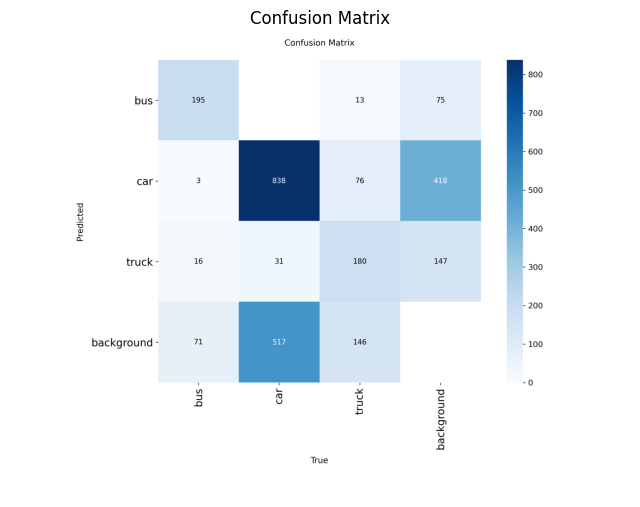

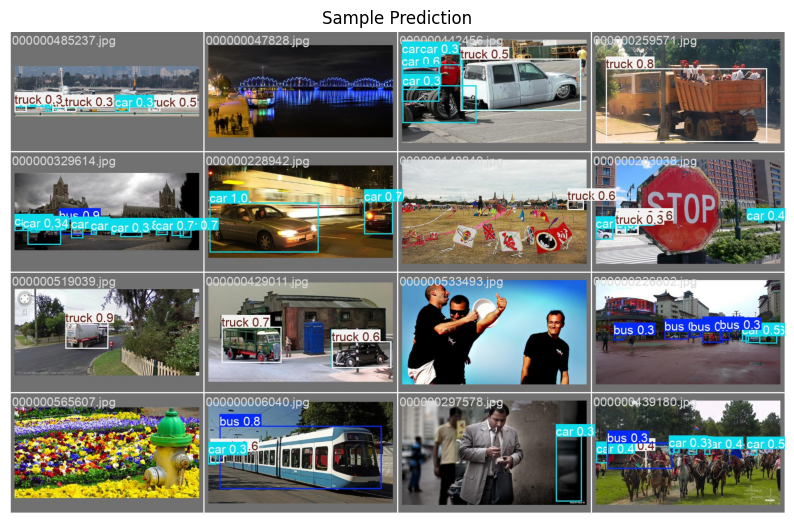

In [53]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to your YOLO experiment results
folder = "/content/runs/train/vehicle_detection_exp_11s_2"

# Example: show confusion matrix
img_path = os.path.join(folder, "confusion_matrix.png")
img = Image.open(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Confusion Matrix")
plt.show()

# Example: show predicted bounding boxes
pred_img = Image.open(os.path.join(folder, "val_batch0_pred.jpg"))
plt.figure(figsize=(10, 10))
plt.imshow(pred_img)
plt.axis('off')
plt.title("Sample Prediction")
plt.show()


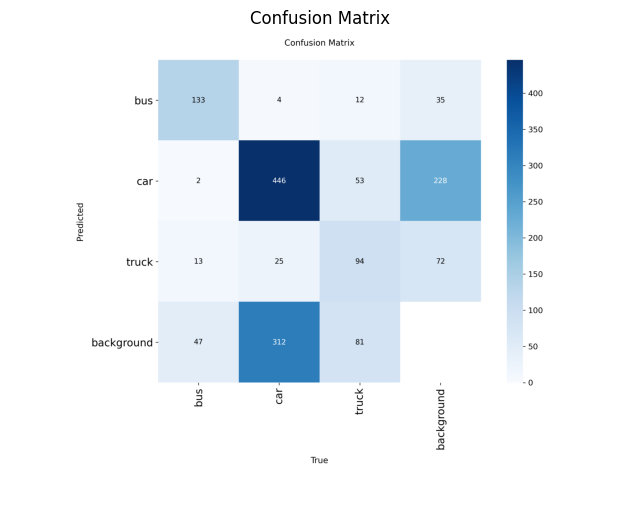

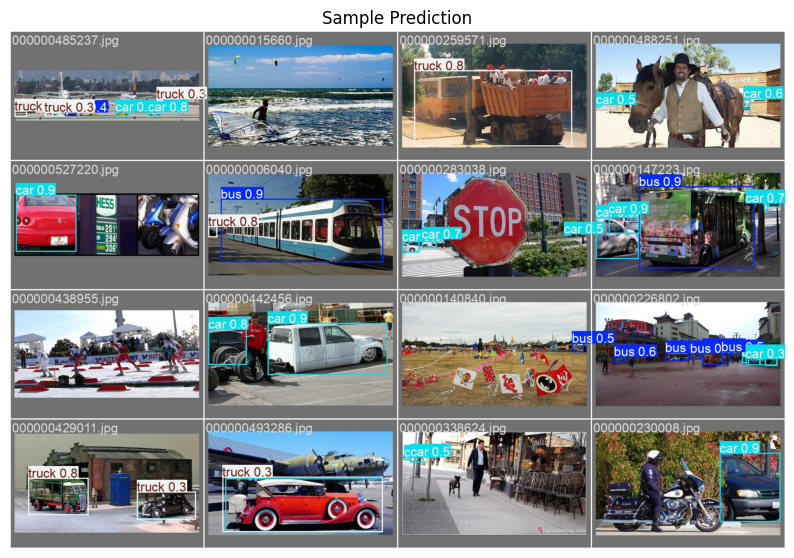

In [54]:
# Path to your YOLO experiment results
folder = "/content/runs/train/vehicle_detection_exp_11s"

# Example: show confusion matrix
img_path = os.path.join(folder, "confusion_matrix.png")
img = Image.open(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Confusion Matrix")
plt.show()

# Example: show predicted bounding boxes
pred_img = Image.open(os.path.join(folder, "val_batch0_pred.jpg"))
plt.figure(figsize=(10, 10))
plt.imshow(pred_img)
plt.axis('off')
plt.title("Sample Prediction")
plt.show()
